In [1]:
import numpy as np
import matplotlib.pyplot as plt

class PIDController:
    def __init__(self, kp, ki, kd, setpoint):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.integral = 0
        self.prev_error = 0

    def compute(self, current_position, dt):
        # Calculate the error
        error = self.setpoint - current_position

        # Proportional term
        p_term = self.kp * error

        # Integral term
        self.integral += error * dt
        i_term = self.ki * self.integral

        # Derivative term
        derivative = (error - self.prev_error) / dt
        d_term = self.kd * derivative

        # Save current error for next derivative calculation
        self.prev_error = error

        # Output current for servo motor
        current_output = p_term + i_term + d_term
        return current_output


In [2]:
class ServoMotorSimulator:
    def __init__(self, initial_position=0):
        self.position = initial_position
        self.velocity = 0

    def apply_current(self, current, dt):
        # Assuming current directly changes position for simplicity (this is a basic assumption)
        self.velocity += current * dt  # Change in velocity due to current
        self.position += self.velocity * dt  # Update position based on velocity


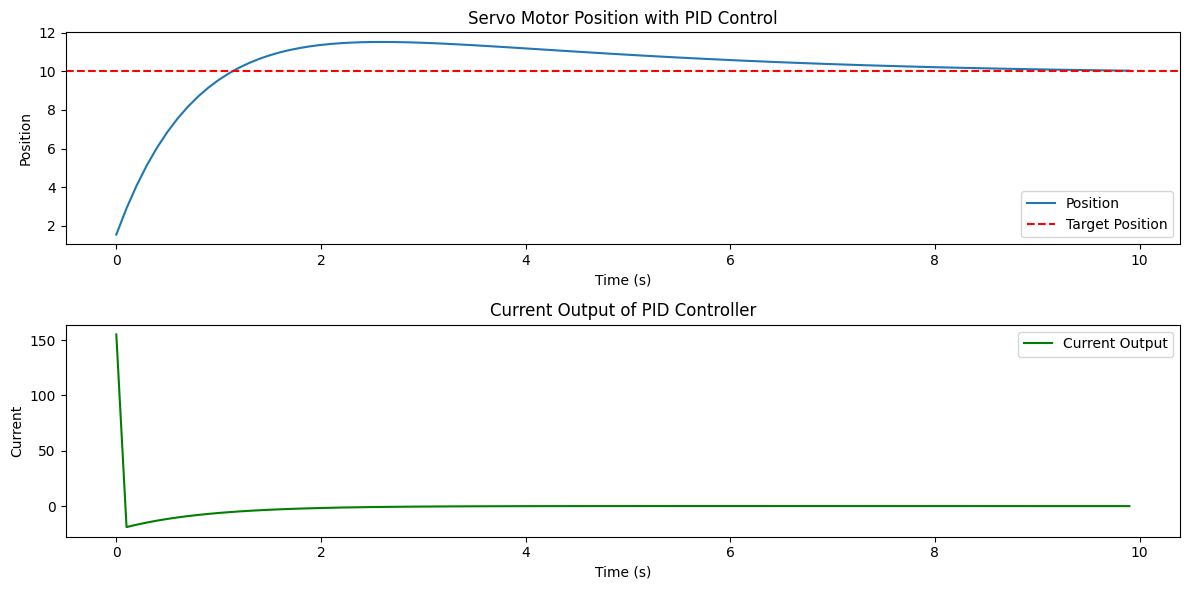

In [19]:
# Parameters
target_position = 10  # Target position in arbitrary units
kp, ki, kd = 0.5, 0.05, 1.5  # PID gains
dt = 0.1  # Time step in seconds
simulation_time = 10  # Total simulation time in seconds

# Initialize PID controller and motor simulator
pid = PIDController(kp=kp, ki=ki, kd=kd, setpoint=target_position)
motor = ServoMotorSimulator()

# Lists for plotting
time_points = np.arange(0, simulation_time, dt)
position_points = []
current_points = []

# Simulation loop
for t in time_points:
    # Calculate current from PID controller
    current = pid.compute(motor.position, dt)

    # Apply current to the motor
    motor.apply_current(current, dt)

    # Log data for plotting
    position_points.append(motor.position)
    current_points.append(current)

# Plotting results
plt.figure(figsize=(12, 6))

# Position Plot
plt.subplot(2, 1, 1)
plt.plot(time_points, position_points, label="Position")
plt.axhline(y=target_position, color="r", linestyle="--", label="Target Position")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.legend()
plt.title("Servo Motor Position with PID Control")

# Current Plot
plt.subplot(2, 1, 2)
plt.plot(time_points, current_points, label="Current Output", color="g")
plt.xlabel("Time (s)")
plt.ylabel("Current")
plt.legend()
plt.title("Current Output of PID Controller")

plt.tight_layout()
plt.show()
